In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils import data
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [0]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.cuda.current_device(), torch.cuda.device_count()

(0, 1)

In [0]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))
                       ])),
        batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,))
                    ])),
    batch_size=batch_size, shuffle=True)

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7f073699f6a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f073699f7b8>)

In [0]:
??nn.ConvTranspose2d

In [0]:
class Generator(nn.Module):
  def __init__(self):
    '''
    Network is a map from one image to another image
    (Batch, 1, w, h) -> (Batch, 1, w, h)
    (Batch, 1, w, h) -> 2ConvDown -> Flatten -> FC -> Bottleneck -> FC -> Reshape -> 2ConvUp -> (Batch, 1, w, h)
    '''
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(128, 256)
    self.fc2 = nn.Linear(256, 512)
    self.fc3 = nn.Linear(512, 1024)
    self.fc4 = nn.Linear(1024, 784)

  def forward(self, z):
    # Down
    z = self.fc1(z)
    z = nn.LeakyReLU(0.2)(z)
    z = self.fc2(z)
    z = nn.LeakyReLU(0.2)(z) 
    z = self.fc3(z)
    z = nn.LeakyReLU(0.2)(z)
    z = self.fc4(z)
    z = nn.Tanh()(z)
    z = z.view((-1, 1, 28, 28))
    return z 




class Discriminator(nn.Module):
  def __init__(self):
    '''
    Network is a map from an image to (0, 1)
    (Batch, 1, w, h) -> (Batch, )
    '''
    super(Discriminator, self).__init__()
    self.fc1 = nn.Linear(784, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 256)
    self.fc4 = nn.Linear(256, 1)

  
  def forward(self, x):
    x = x.view((-1, 784))
    x = self.fc1(x)
    x = nn.LeakyReLU(0.2)(x)
    x = self.fc2(x)
    x = nn.LeakyReLU(0.2)(x)
    x = self.fc3(x)
    x = nn.LeakyReLU(0.2)(x)
    x = self.fc4(x)
    return nn.Sigmoid()(x)


generator = Generator()
discriminator = Discriminator()
generated = generator(torch.randn(10, 128))

predictions = discriminator(generated)
next(discriminator.parameters()).is_cuda

True

In [0]:
G = Generator()
D = Discriminator()

G_optimizer = optim.Adam(G.parameters(), lr = 2e-4)
D_optimizer = optim.Adam(D.parameters(), lr = 2e-4)


def train(G, D, G_optimizer, D_optimizer, train_loader):
  G_losses = []
  D_losses = []
  transform = transforms.Compose([
    transforms.Normalize(mean=[0.5,],
                         std=[0.5,])])
  for i, (X, Y) in enumerate(train_loader):
    
    # train D
    Z = torch.randn((X.shape[0], 128))
    D.zero_grad()
    X = X.cuda()
    for p in D.parameters(): p.requires_grad = True
    D_loss = nn.BCELoss()(D(X), torch.ones((X.shape[0], 1))) + nn.BCELoss()(D(G(Z)), torch.zeros((X.shape[0], 1)))
    D_loss.backward(retain_graph=True)
    D_optimizer.step()

    # train G
    G.zero_grad()
    for p in D.parameters(): p.requires_grad = False
    
    G_loss = nn.BCELoss()(D(G(Z)), torch.ones((X.shape[0], 1)))

    G_loss.backward()
    G_optimizer.step()
    
    G_losses.append(G_loss.mean().item())
    D_losses.append(D_loss.mean().item())

    if i % 100 == 0:
      print(D_loss.mean().item(), G_loss.mean().item())

for epoch in range(100):
  print(epoch)
  train(G, D, G_optimizer, D_optimizer, train_loader)

0
1.371835708618164 0.7095200419425964
1.371835708618164 0.7095200419425964
1.0545904636383057 1.354474425315857
1.0545904636383057 1.354474425315857
0.30138832330703735 3.6802074909210205
0.30138832330703735 3.6802074909210205
0.07480015605688095 4.9354987144470215
0.07480015605688095 4.9354987144470215
0.17262986302375793 5.386603355407715
0.17262986302375793 5.386603355407715
1.6198028326034546 1.2502999305725098
1.6198028326034546 1.2502999305725098
1
5.250648021697998 1.9507369995117188
5.250648021697998 1.9507369995117188
2.2041683197021484 0.7502901554107666
2.2041683197021484 0.7502901554107666
1.691211223602295 1.0895136594772339
1.691211223602295 1.0895136594772339
0.40799152851104736 2.6063263416290283
0.40799152851104736 2.6063263416290283
0.4475805163383484 2.1851463317871094
0.4475805163383484 2.1851463317871094
0.17840512096881866 6.090256214141846
0.17840512096881866 6.090256214141846
2
1.5361545085906982 2.676398754119873
1.5361545085906982 2.676398754119873
0.23142124

torch.Size([10, 128])
-709.21893 -455.16364


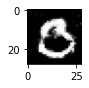

-739.78906 -555.138


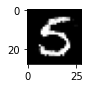

-826.5365 -470.3515


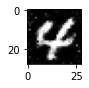

-743.45105 -665.77496


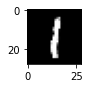

-773.8351 -516.0128


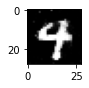

-638.9217 -550.7738


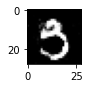

-817.7451 -658.7029


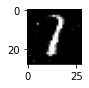

-775.82916 -503.31372


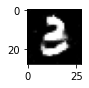

-766.0582 -587.3187


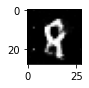

-784.4939 -627.9015


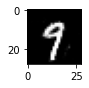

In [0]:
def tensor2image(x):
  return x.detach().numpy().transpose(0, 2, 3, 1)

def image2tensor(x):
  return torch.tensor(x.transpose(0, 3, 1, 2))

def display_image(image):
  plt.figure(figsize=(1,1))
  plt.imshow(image[:,:,0], cmap = 'gray')
  plt.show()


transform = transforms.Compose([
  transforms.Normalize(mean=[0.5,],
                        std=[0.5,])])
inputs = torch.randn((10, 128))
print(inputs.shape)
predictions = G(inputs).cpu()
predictions_numpy = tensor2image(predictions.cpu())
for j, (inpt, prediction) in enumerate(zip(inputs_numpy, predictions_numpy)):
  print(inpt.sum(), prediction.sum())
  display_image(prediction)
  if j > 20:
    break